<a href="https://colab.research.google.com/github/Page0526/Pytorch-crash-course/blob/main/deep-neural-networks/nlp/Neural_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipympl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

In [ ]:
train_data = """A closed-loop controller or feedback controller is a control loop which incorporates feedback, in contrast to an open-loop controller or non-feedback controller. A closed-loop controller uses feedback to control states or outputs of a dynamical system. Its name comes from the information path in the system: process inputs (e.g., voltage applied to an electric motor) have an effect on the process outputs (e.g., speed or torque of the motor), which is measured with sensors and processed by the controller; the result (the control signal) is "fed back" as input to the process, closing the loop"""
test_data = "TBD"

In [ ]:
import tqdm
import re

def processing(text: str):
  text = text.lower()
  corpus = re.sub(r'[^a-z\s]', '', text).split()
  vocab = sorted(set(corpus))
  vocab.append('<pad>')
  vocab.append('<unk>')
  word_2_id = {w: i for i, w in enumerate(vocab)}
  id_2_word = {i: w for i, w in enumerate(vocab)}
  text_id = [word_2_id[w] for w in corpus]

  return corpus, vocab, text_id, word_2_id, id_2_word

corpus, vocab, text_id, word_2_id, id_2_word = processing(train_data)

V = len(vocab)
D = 100
N = 5
n_hidden = 512
net = nn.Sequential(
    nn.Embedding(num_embeddings=V, embedding_dim=D),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Flatten(),
    nn.Linear(in_features=D*N, out_features=n_hidden),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Linear(in_features=n_hidden, out_features=n_hidden),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Linear(in_features=n_hidden, out_features=V)
)

def train(text_id: list, net: nn.Module, lr: float, optimizer: str, nepochs: int, N: int):
  fig,ax = plt.subplots(1,1)
  losses = []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=lr) if optimizer == "adam" else optim.SGD(net.parameters(), lr=lr)
  for ei in tqdm.trange(nepochs):
    for i in range(len(text_id) - N):
      inputs = torch.LongTensor(text_id[i:i+N]).reshape(1, -1)
      target = torch.LongTensor([text_id[i+N]])
      output = net(inputs)
      loss = criterion(output, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    fig.canvas.flush_events()
    # test()    # perplexity
  return net


def test(text: str, net: nn.Module):
  pass


def text2id(text):
  corpus = text.lower()
  corpus = re.sub(r'[^a-z\s]', '', corpus).split()
  text_id = [word_2_id.get(w, V - 1) for w in corpus]
  return text_id


def predict(net: nn.Module, text: str, N: int):
  text_id = text2id(text)
  if len(text_id) < N:
    text_id = [word_2_id['<pad>']] * (N - len(text_id)) + text_id
  text_id = text_id[-N:]
  # print(f"{text_id=}")
  prob = net(torch.LongTensor(text_id).reshape(1, -1))
  prob = torch.softmax(prob, dim=1)
  # print(f"{prob=}")
  next_word_id = torch.argmax(prob).item()
  # print(f"{next_word_id=}")
  return id_2_word[next_word_id], prob.detach().numpy()[0]


def perplexity(net: nn.Module, text: str):
  pass

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Sequential(
  (0): Embedding(56, 100)
  (1): LeakyReLU(negative_slope=0.15)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=500, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.15)
  (5): Linear(in_features=512, out_features=512, bias=True)
  (6): LeakyReLU(negative_slope=0.15)
  (7): Linear(in_features=512, out_features=56, bias=True)
)

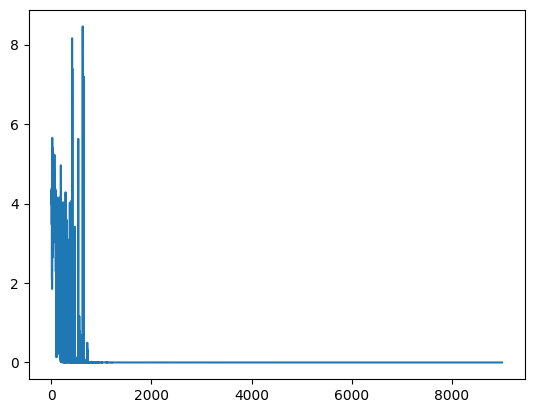

In [ ]:
train(text_id, net, lr=1e-3, optimizer='adam', nepochs=100, N=5)

Support for third party widgets will remain active for the duration of the session. To disable support:

next_word='controller'
a 0.0013727351324632764
an 0.00036907591857016087
and 0.0006267359131015837
applied 0.011942793615162373
as 0.0002375454641878605
back 0.00016682851128280163
by 0.004325773101300001
closedloop 0.00025173614267259836
closing 0.002861523535102606
comes 0.00035118096275255084
contrast 0.0001340117451036349
control 0.00016420558677054942
controller 0.8924869298934937
dynamical 0.00016883158241398633
effect 0.0005489497561939061
eg 0.0013374312547966838
electric 0.0011055131908506155
fed 0.0007834807620383799
feedback 0.0011152984807267785
from 0.0011248779483139515
have 8.882412657840177e-05
in 0.0015097688883543015
incorporates 0.0011001315433532
information 9.753402991918847e-05
input 0.004041056148707867
inputs 0.00012082361354259774
is 6.0804759414168075e-05
its 8.749007247388363e-05
loop 0.00014637068670708686
measured 0.0004880970227532089
motor 0.002974588656798005
name 0.00028950898558832705
nonfeedback 0.00030971295200288296
of 0.0009395553497597575
on 0.014

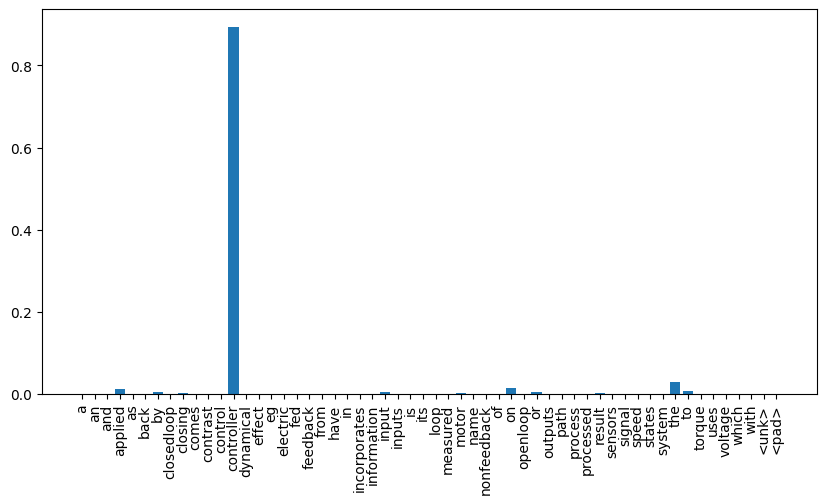

In [ ]:
next_word, prob = predict(net, "closedloop", N=5)
print(f"{next_word=}")
print()
print("Prob")
print("\n".join([f"{id_2_word[i]} {prob[i]}" for i in range(len(prob))]))
plt.figure(figsize=(10, 5))
plt.bar(range(len(prob)), prob)
plt.xticks(range(len(prob)), id_2_word.values(), rotation=90)
plt.show()

In [ ]:
test_perplexity = perplexity(net: nn.Module, test_data)
print(f"Test perplexity: {test_perplexity}")

56


In [ ]:
# generate 100 words from the model